In [130]:
import matplotlib

"""
Author: Valentina Matos (Johns Hopkins - Wirtz/Kiemen Lab)
Date: May 29, 2024
"""

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2" #prevents showing information/warning logs from TensorFlow
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, UpSampling2D
from tensorflow.keras.layers import AveragePooling2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
import pickle
from glob import glob

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.optimizers import Adam


In [131]:
""" Atrous Spatial Pyramid Pooling """
'''
https://github.com/nikhilroxtomar/Semantic-Segmentation-Architecture/blob/main/TensorFlow/deeplabv3plus.py
https://github.com/Wirtz-Lab/wsi_analysis/blob/master/kyu/deeplab/train_v1.ipynb
The ASPP block consists of five parallel groups of layers. These are:

1. Image pooling
2. 1×1 convolution
3. Three dilated convolutions with dilation rates of 6, 12 and 18 respectively.

'''
def ASPP(inputs):
    shape = inputs.shape

    y_pool = AveragePooling2D(pool_size=(shape[1], shape[2]), name='average_pooling')(inputs)
    y_pool = Conv2D(filters=256, kernel_size=1, padding='same', use_bias=False)(y_pool)
    y_pool = BatchNormalization(name=f'bn_1')(y_pool)
    y_pool = Activation('relu', name=f'relu_1')(y_pool)
    y_pool = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y_pool)

    y_1 = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(inputs)
    y_1 = BatchNormalization()(y_1)
    y_1 = Activation('relu')(y_1)

    y_6 = Conv2D(filters=256, kernel_size=3, dilation_rate=6, padding='same', use_bias=False)(inputs)
    y_6 = BatchNormalization()(y_6)
    y_6 = Activation('relu')(y_6)

    y_12 = Conv2D(filters=256, kernel_size=3, dilation_rate=12, padding='same', use_bias=False)(inputs)
    y_12 = BatchNormalization()(y_12)
    y_12 = Activation('relu')(y_12)

    y_18 = Conv2D(filters=256, kernel_size=3, dilation_rate=18, padding='same', use_bias=False)(inputs)
    y_18 = BatchNormalization()(y_18)
    y_18 = Activation('relu')(y_18)

    y = Concatenate()([y_pool, y_1, y_6, y_12, y_18])

    y = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    return y

In [132]:
def DeepLabV3Plus(shape, num_classes):
    """ Inputs """
    inputs = Input(shape)

    """ Pre-trained ResNet50 """
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)

    """ Pre-trained ResNet50 Output """
    image_features = base_model.get_layer('conv4_block6_out').output
    x_a = ASPP(image_features)
    x_a = UpSampling2D((4, 4), interpolation="bilinear")(x_a)
    print(x_a.shape)

    """ Get low-level features """
    x_b = base_model.get_layer('conv2_block2_out').output
    x_b = Conv2D(filters=48, kernel_size=1, padding='same', use_bias=False)(x_b)
    x_b = BatchNormalization()(x_b)
    x_b = Activation('relu')(x_b)

    """ Up-sample x_b to match x_a """ #VALENTINA WDIT
    # x_b = UpSampling2D(size=(2, 2))(x_b)  # Up-sample x_b to match the spatial dimensions of x_a

    x = Concatenate()([x_a, x_b])

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((4, 4), interpolation="bilinear")(x)

    """ Outputs """
    x = Conv2D(num_classes, (1, 1), name='output_layer')(x)
    x = Activation('softmax')(x) #softmax activation for multiclass segmentation

    """ Model """
    model = Model(inputs=inputs, outputs=x)
    return model
# if __name__ == '__main__':
#     input_shape = (1024, 1024, 3)
#     DeepLabV3Plus(input_shape, num_classes=11)

In [133]:
import subprocess
# Check the number of GPUs available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

try:
    # Get the name of the GPU
    output = subprocess.check_output(['nvidia-smi', '--query-gpu=gpu_name', '--format=csv,noheader'])
    gpu_name = output.decode('utf-8').strip()
    print(f"GPU Name: {gpu_name}")
except (subprocess.CalledProcessError, FileNotFoundError):
    print("Unable to retrieve GPU information")

Num GPUs Available:  1
GPU Name: NVIDIA GeForce RTX 3090


In [134]:
# Inputs
pthDL = r'\\10.99.68.52\Kiemendata\Valentina Matos\coda to python\test model\model test tiles'

In [135]:
# Load variables from pickle file
with open(os.path.join(pthDL, 'net.pkl'), 'rb') as f:
    data = pickle.load(f)
    sxy, classNames, nm = data['sxy'], data['classNames'], data['nm']

if 'net' in data:
    raise ValueError(f"A network has already been trained for model {nm}. Choose a new model name to retrain.")
else:
    # rest of the code here
    pass  # --delete pass when the rest of the code is placed below the else statement


In [136]:
# Paths to training and validation datasets:
pthDataset = r'\\10.99.68.52\Kiemendata\Valentina Matos\coda to python\test_png'

# Define paths to training and validation directories
pthTrain = os.path.join(pthDataset, 'training')
pthValidation = os.path.join(pthDataset, 'validation')

# Get paths to training images and labels
Train_HE = sorted(glob(os.path.join(pthTrain, 'im','resized_1024', "*.png")))
Train_label = sorted(glob(os.path.join(pthTrain, 'label','resized_1024', "*.png")))

# Get paths to validation images and labels
Validation_HE = sorted(glob(os.path.join(pthValidation, 'im','resized_1024', "*.png")))
Validation_label = sorted(glob(os.path.join(pthValidation, 'label','resized_1024', "*.png")))

# Print the number of elements in each dataset
print(f"Number of elements in Train_HE: {len(Train_HE)}")
print(f"Number of elements in Train_label: {len(Train_label)}")
print(f"Number of elements in Validation_HE: {len(Validation_HE)}")
print(f"Number of elements in Validation_label: {len(Validation_label)}")

Number of elements in Train_HE: 1500
Number of elements in Train_label: 1500
Number of elements in Validation_HE: 300
Number of elements in Validation_label: 300


In [137]:
class CustomDataGenerator:
    def __init__(self, image_list, mask_list, batch_size, image_size, num_classes):
        """
        Initialize the data generator with image paths, mask paths, batch size, and image size.

        Args:
        - image_list: List of paths to the images.
        - mask_list: List of paths to the masks.
        - batch_size: Size of the batches of data.
        - image_size: Size to which images will be resized.
        """
        self.image_list = image_list
        self.mask_list = mask_list
        self.batch_size = batch_size
        self.image_size = image_size
        self.num_classes = num_classes


    def read_image(self, image_path, mask=False):
        """
        Read and preprocess an image or mask.

        Args:
        - image_path: Path to the image or mask.
        - mask: Boolean indicating if the image is a mask.

        Returns:
        - Preprocessed image or mask.
        """
        # Read the image file
        try:
            image = tf.io.read_file(image_path)
            
            if mask:
                # Decode the image as a grayscale (single-channel) image
                image = tf.image.decode_png(image, channels=1)
                # Set the shape of the image
                image.set_shape([None, None, 1])
                # Resize the image to the specified size
                image = tf.image.resize(images=image, size=[self.image_size, self.image_size])
                # Convert grayscale mask to one-hot encoding
                image = tf.cast(image, tf.int32) # Cast the mask to integer type before one-hot encoding
                image = tf.one_hot(tf.squeeze(image, axis=-1), self.num_classes)
            
            else:
                # Decode the image as a color (three-channel) image
                image = tf.image.decode_png(image, channels=3)
                # Set the shape of the image
                image.set_shape([None, None, 3])
                # Resize the image to the specified size
                image = tf.image.resize(images=image, size=[self.image_size, self.image_size])
                # Normalize the image to the range [0, 1]
                image = image / 255.0
            
            return image
        
        except tf.errors.InvalidArgumentError as e:
            print(f"Error reading image {image_path}: {e}")
            return None  

    def load_data(self, image_path, mask_path):
        """
        Load and preprocess an image and its corresponding mask.

        Args:
        - image_path: Path to the image.
        - mask_path: Path to the mask.

        Returns:
        - Tuple of (image, mask).
        """
        image = self.read_image(image_path)
        mask = self.read_image(mask_path, mask=True)
        return image, mask

    def data_generator(self):
        """
        Create a TensorFlow dataset generator.

        Returns:
        - A batched TensorFlow dataset.
        """
        # Check that image_list and mask_list have the same length
        assert len(self.image_list) == len(self.mask_list), "Number of images and masks must be the same."

        # Create a dataset from the image and mask paths
        dataset = tf.data.Dataset.from_tensor_slices((self.image_list, self.mask_list))
        # Map the load_data function to each element in the dataset using a lambda function
        dataset = dataset.map(lambda x, y: self.load_data(x, y), num_parallel_calls=tf.data.AUTOTUNE)
        # Batch the dataset
        dataset = dataset.batch(self.batch_size, drop_remainder=True)
        return dataset


In [138]:
numclasses = len(classNames)
print(numclasses)

training_data_gen = CustomDataGenerator(Train_HE, Train_label, batch_size=4, image_size=1024, num_classes=numclasses)
validation_data_gen = CustomDataGenerator(Validation_HE, Validation_label, batch_size=4, image_size=1024,num_classes=numclasses)
# Get the datasets
train_dataset = training_data_gen.data_generator()
val_dataset = validation_data_gen.data_generator()
print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)

12
Train Dataset: <BatchDataset element_spec=(TensorSpec(shape=(4, 1024, 1024, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 1024, 1024, 12), dtype=tf.float32, name=None))>
Val Dataset: <BatchDataset element_spec=(TensorSpec(shape=(4, 1024, 1024, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 1024, 1024, 12), dtype=tf.float32, name=None))>


In [139]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
numclasses = len(classNames)
print(numclasses)
model = DeepLabV3Plus(shape=(1024, 1024, 3), num_classes=numclasses)
model.summary()

12
(None, 256, 256, 256)
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 1024, 1024,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 1030, 1030,   0           ['input_7[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, 512, 512, 64  9472        ['conv1_pad[0][0]']              
                                )                                  

In [140]:
#Compile model:
model.compile(optimizer=Adam(), loss=categorical_crossentropy, metrics=['accuracy'])

In [141]:
# Define the learning rate schedule
def step_decay(epoch):
    initial_lr = 0.001
    drop_rate = 0.5
    epoch_drop = 5
    lrate = initial_lr * drop_rate ** (epoch // epoch_drop)
    return lrate

# Create the learning rate scheduler callback
lr_scheduler = LearningRateScheduler(step_decay)

In [142]:
# Create the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

In [143]:
import time
# Ensure TensorFlow is set to use the GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        # Set memory growth to avoid using all GPU memory
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
        tf.config.set_visible_devices(physical_devices[0], 'GPU')
        logical_devices = tf.config.list_logical_devices('GPU')
        print(f"TensorFlow is using the following GPU: {logical_devices[0]}")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("No GPU available. Ensure that the NVIDIA GPU and CUDA are correctly installed.")

# Assuming model, train_dataset, val_dataset, lr_scheduler, and early_stopping are already defined

#### Train the model
start = time.time()
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=8,
    callbacks=[lr_scheduler, early_stopping]
)
training_time = time.time() - start
hours, rem = divmod(training_time, 3600)
minutes, seconds = divmod(rem, 60)
print(f"Training time: {int(hours)}h {int(minutes)}m {int(seconds)}s")

# Print the current learning rate
print(f"Learning Rate: {round(model.optimizer.lr.numpy(), 5)}")


Physical devices cannot be modified after being initialized
Num GPUs Available:  1
GPU Name: NVIDIA GeForce RTX 3090
Epoch 1/8
375/375 [==============================] - 7740s 21s/step - loss: 0.3916 - accuracy: 0.4508 - val_loss: 1.8685 - val_accuracy: 0.1073 - lr: 0.0010
Epoch 2/8
375/375 [==============================] - 9071s 24s/step - loss: 0.3824 - accuracy: 0.4799 - val_loss: 2.5268 - val_accuracy: 0.0834 - lr: 0.0010
Epoch 3/8
375/375 [==============================] - 7655s 20s/step - loss: 0.7239 - accuracy: 0.4204 - val_loss: 1.2257 - val_accuracy: 0.2099 - lr: 0.0010
Epoch 4/8
375/375 [==============================] - 7641s 20s/step - loss: 0.8893 - accuracy: 0.3476 - val_loss: 1.3241 - val_accuracy: 0.1849 - lr: 0.0010
Epoch 5/8
375/375 [==============================] - 7667s 20s/step - loss: 0.9614 - accuracy: 0.3130 - val_loss: 1.2487 - val_accuracy: 0.1842 - lr: 0.0010
Epoch 6/8
375/375 [==============================] - 7630s 20s/step - loss: 0.8676 - accuracy: 0.3

In [145]:
# Save the model
print('Saving model weights...')
data['net'] = model.get_weights()  # Get the model weights
data['history'] = history.history  # Get the model history

with open(os.path.join(pthDL, 'net.pkl'), 'wb') as f:
    pickle.dump(data, f)
    

Saving model weights...


In [147]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the CSV file into a DataFrame
with open(os.path.join(pthDL, 'net.pkl'), 'rb') as f:
    data = pickle.load(f)
history = data['history']
history_df = pd.DataFrame(history)
history_df

,loss,accuracy,val_loss,val_accuracy,lr
0,0.391611,0.450768,1.868510,0.107290,0.0010
1,0.382447,0.479890,2.526756,0.083385,0.0010
2,0.723924,0.420408,1.225717,0.209941,0.0010
3,0.889327,0.347632,1.324056,0.184869,0.0010
4,0.961391,0.312950,1.248682,0.184219,0.0010
5,0.867619,0.327336,1.152678,0.228757,0.0005
6,0.860741,0.323796,1.149138,0.209816,0.0005
7,0.834532,0.352633,1.136479,0.229934,0.0005


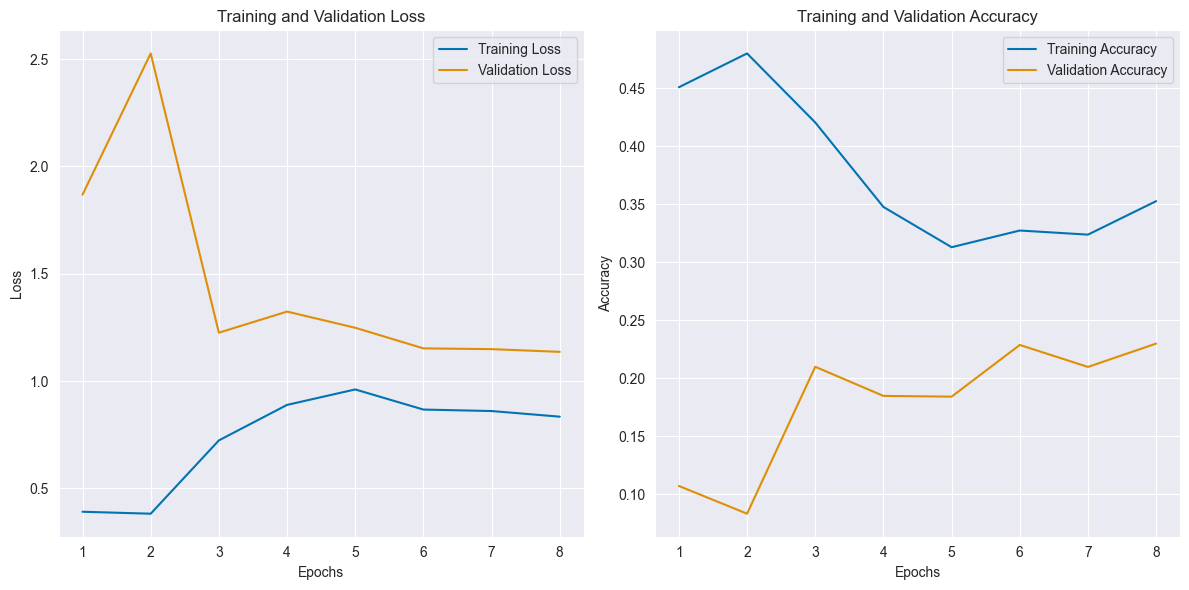

In [151]:

# Use seaborn color palette
sns.set_palette("colorblind")

# Plot loss and accuracy in a single figure
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
sns.lineplot(data=history_df,x= range(1,9), y='loss', label='Training Loss')
sns.lineplot(data=history_df,x= range(1,9), y='val_loss', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
sns.lineplot(data=history_df, x= range(1,9), y='accuracy', label='Training Accuracy')
sns.lineplot(data=history_df, x= range(1,9), y='val_accuracy', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()

In [174]:
#_____________Code to segment an image___________

#Load  weights:
with open(os.path.join(pthDL, 'net.pkl'), 'rb') as f:
    data = pickle.load(f)
    history = data['history']
    saved_weights = data['net']
    classNames = data['classNames']
    colormap = data['cmap']
    
#Image to segment:
path_image = r'\\10.99.68.52\Kiemendata\Valentina Matos\coda to python\test png\training\im\10.png'
image = tf.io.read_file(path_image)
image = tf.io.decode_image(image, channels=3)

input_shape = image.shape
numclasses = len(classNames)

#Create model and load weights
model = DeepLabV3Plus(shape=input_shape, num_classes=numclasses)
model.set_weights(saved_weights)
print('Model weights loaded.')

#Funnction to segment image

def segment_image(model, path_image, numclasses):
    image = tf.io.read_file(path_image)
    image = tf.io.decode_image(image, channels=3, dtype=tf.float32)  # Convert to float32
    image = image / 255.0 #normalize
    image = tf.expand_dims(image, axis=0)  # Add batch dimension
    predictions = model.predict(image)
    predictions = tf.argmax(predictions, axis=-1)
    predictions = tf.squeeze(predictions, axis=0)
    
    return predictions

# Segment the image
segmented_image = segment_image(model, path_image, numclasses)


(None, 256, 256, 256)
Model weights loaded.
1/1 [==============================] - 1s 1s/step


In [176]:
# Function to save the segmented image in grayscale
def save_segmented_image_grayscale(segmented_image, save_path):
    # Convert the tensor to a numpy array
    segmented_image = segmented_image.numpy().astype(np.uint8)
    
    # Convert to PIL Image and save
    segmented_image_pil = Image.fromarray(segmented_image, mode='L') #'L' is for grayscale mode
    os.makedirs(os.path.dirname(save_path), exist_ok = True)
    segmented_image_pil.save(save_path)

# Save the segmented image in grayscale
save_path = r'\\10.99.68.52\Kiemendata\Valentina Matos\coda to python\test png\segmented\segmented_10.png'

save_segmented_image_grayscale(segmented_image, save_path)
print(f'Segmented image saved to {save_path}')

Segmented image saved to \\10.99.68.52\Kiemendata\Valentina Matos\coda to python\test png\segmented\segmented_10.png


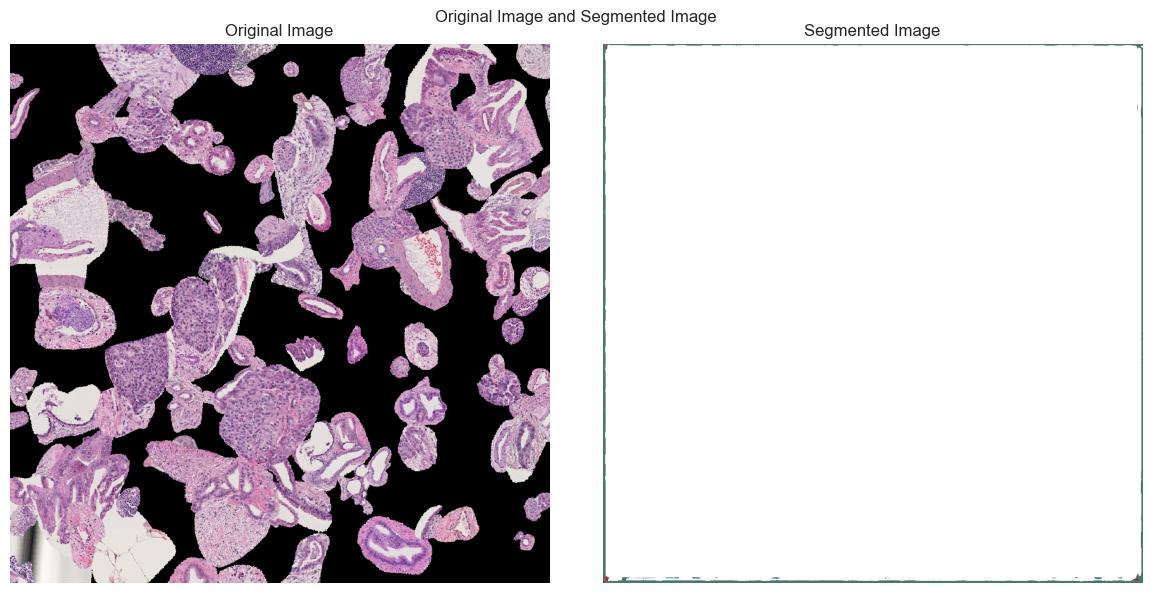

In [163]:
import numpy as np
from PIL import Image

# Plot the original image and the segmented image
plt.figure(figsize=(12, 6))
plt.suptitle("Original Image and Segmented Image")

# Original Image
plt.subplot(1, 2, 1)
# original_image = tf.io.read_file(path_image)
# original_image = tf.image.decode_image(original_image, channels=3)
# plt.imshow(original_image.numpy().astype("uint8"))
# original_image_np = np.asarray(original_image)  # Convert PIL.Image to NumPy array
# plt.title("Original Image")
# plt.axis('off')


# Segmented Image
plt.subplot(1, 2, 2)
segmented_image_rgb = np.zeros((segmented_image.shape[0], segmented_image.shape[1], 3), dtype=np.uint8)
for label in np.unique(segmented_image):
    segmented_image_rgb[segmented_image == label] = colormap[label]
plt.imshow(segmented_image_rgb)
plt.title("Segmented Image")
plt.axis('off')

plt.tight_layout()
plt.show()

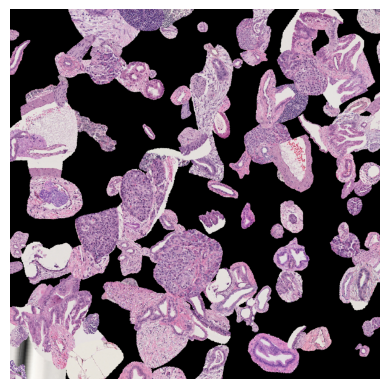

In [172]:
from PIL import Image

# Load the image
path_image = r'\\10.99.68.52\Kiemendata\Valentina Matos\coda to python\test png\training\im\10.png'
image = Image.open(path_image)

# Display the image
plt.imshow(image)
plt.axis('off')  # Hide the axes
plt.show()

In [1]:
import tensorflow as tf

print('Tensorflow version', tf.__version__)

Tensorflow version 2.16.1
